# 在<b>`Oracle Data Science`</b>平台运行基于卷积神经网络的肺炎检测算法，并生成可复用的模型

声明：本示例仅用于演示Oracle Data Science的功能，所用算法源于Github和Kaggle的开源项目。算法仅供学习、研究使用，请谨慎用于实际生产环境。

附录：
 - 来源1：[Github项目 作者：JordanMicahBennett](https://github.com/JordanMicahBennett/SMART-CT-SCAN_BASED-COVID19_VIRUS_DETECTOR)
 - 来源2：[Kaggle项目 作者：Paul Mooney](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/)

### 步骤：

1. <a href='#network'>用`Keras`生成卷积神经网络模型</a>
2. <a href='#evaluate'>用covid19测试集检验模型效果</a>
3. <a href='#save_model'>用ADS转换和保存模型，上传到`Oracle Data Science`的模型目录</a>

In [1]:
# 导入常规包
import os
import numpy as np
import random
import cv2
import pandas as pd
from matplotlib import pyplot as plt

# 导入深度学习包
from sklearn.metrics import accuracy_score, confusion_matrix
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

# disabling warnings
import logging
logging.getLogger('tensorflow').disabled = True

pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)

Using TensorFlow backend.


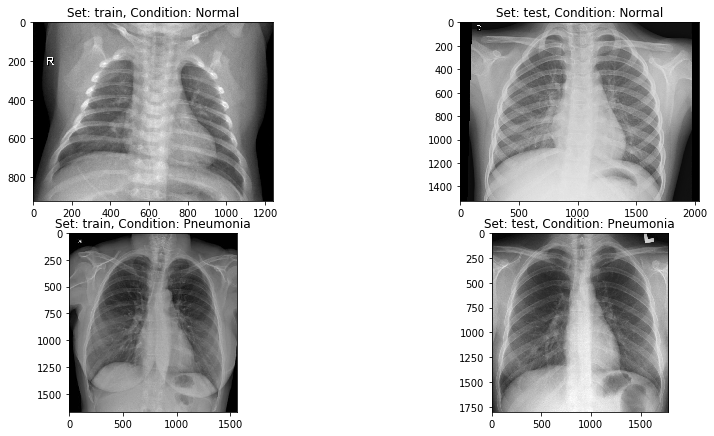

In [2]:
# 查看示例图像
input_path = 'xray_dataset_covid19/'
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+2].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+2].set_title('Set: {}, Condition: Pneumonia'.format(_set))

<a id='network'></a>
# 用`Keras`生成卷积神经网络模型

In [3]:
# Hyperparameters
img_dims = 150
epochs = 10
batch_size = 32

# Input layer
inputs = Input(shape=(img_dims, img_dims, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# 创建和编译模型
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.load_weights('best_weights_kaggle_user_pneumonia2_0.hdf5')

# 查看模型概况
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 75, 75, 32)        688       
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 75, 75, 32)        1344      
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 32)        128 

<a id='evaluate'></a>
# 用covid19测试集检验模型效果

In [5]:
test_data,test_labels = [],[]
for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            if not img.startswith('.'):
                img = cv2.imread(input_path+'test/'+cond+img,0) 
                img = cv2.resize(img, (img_dims, img_dims))
                img = np.dstack([img, img, img])
                img = img.astype('float32') / 255
                if cond=='/NORMAL/':
                    label = 0
                elif cond=='/PNEUMONIA/':
                    label = 1
                test_data.append(img)
                test_labels.append(label) 
test_data = np.array(test_data)
test_labels = np.array(test_labels)

# 预测测试集
preds = model.predict(test_data)
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()
acc = accuracy_score(test_labels, np.round(preds))*100
precision = round(tp/(tp+fp)*100,1)
recall = round(tp/(tp+fn)*100,1)
specificity = round(tn/(tn+fp)*100 ,1)
f1 = round(2*precision*recall/(precision+recall),1)

In [6]:
confusion_matrix=[{'混淆矩阵':'预测-阳性','实际-阳性':tp,'实际-阴性':fp},{'混淆矩阵':'预测-阴性','实际-阳性':fn,'实际-阴性':tn}]
df=pd.DataFrame(confusion_matrix)
df=df.set_index('混淆矩阵')
df

,实际-阳性,实际-阴性
混淆矩阵,,
预测-阳性,15,4
预测-阴性,5,16


In [7]:
measures = {'度量名称':['准确率','精确率','召回率','特异度','F1值'],'Measure':['Accuracy','Precision','Recall/Sensitivity','Specificity','F1-score'],'Value':[acc,precision,recall,specificity,f1]}
df2=pd.DataFrame(measures)
df2=df2.set_index('度量名称')
df2

,Measure,Value
度量名称,,
准确率,Accuracy,77.5
精确率,Precision,78.9
召回率,Recall/Sensitivity,75.0
特异度,Specificity,80.0
F1值,F1-score,76.9


<a id='save_model'></a>
# 用ADS转换和保存模型，上传到`Oracle Data Science`的模型目录

In [22]:
from ads.common.model import ADSModel
from ads.common.model_artifact import ModelArtifact

ads_keras_model = ADSModel.from_estimator(model)

model_artifact = ads_keras_model.prepare("/home/datascience/block_storage/ads_keras_model", force_overwrite=True)

saved_model = model_artifact.save(project_id=os.environ['PROJECT_OCID'], 
                               compartment_id=os.environ['NB_SESSION_COMPARTMENT_OCID'], 
                               display_name="胸透图像识别算法",                               
                               description="用于肺炎监测的AI算法", 
                               ignore_pending_changes=True)
saved_model

Generated model artifact files under '/home/datascience/block_storage/ads_keras_model'. Please update the inference script (score.py) as required.


,
id,ocid1.datasciencemodel.oc1.iad.amaaaaaaxc7u3kiaworatxtiaj6agzs3733a7pq5njprtsv7tiexvlwwvrza
compartment_id,ocid1.compartment.oc1..aaaaaaaahnukc4pyf4ugy5ipj7zzvez52r6jg6fxrs6uhurcwrqeudcemhsa
project_id,ocid1.datascienceproject.oc1.iad.amaaaaaaxc7u3kiadw6a666isrhghqxt3mrm366zj3nukx7c7lyorwlzui3a
display_name,胸透图像识别算法
description,用于肺炎监测的AI算法
lifecycle_state,ACTIVE
time_created,2020-03-24 06:57:40.705000+00:00
created_by,ocid1.user.oc1..aaaaaaaa4wjzvgrzw3hj3ftw2tzxfqjsoa7jcbbftv7bkv23a3zd7abc5qeq
freeform_tags,{}
defined_tags,"{'sehub_region_cn': {'principal': 'oracleidentitycloudservice/jingang.liang@oracle.com', 'datetime': '2020-03-24T06:57:40.558Z', 'request_region': 'China'}}"
